In [1]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV, cross_validate, RandomizedSearchCV
from matplotlib import pyplot

pyplot.style.use('default') # para graficos matplotlib
pyplot.rcParams['figure.figsize'] = (10, 8)


from sklearn import metrics
from sklearn.model_selection import train_test_split
pd.set_option('display.float_format', lambda x: '%.5f' % x)


# pd.options.display.float_format = '{:20,.0f}'.format # suprimimos la notacion cientifica en los outputs

In [2]:
path = 'data/'
features = pd.read_csv(path + 'features.csv')
test = pd.read_csv(path + 'testModified.csv')

In [3]:
x = features.drop(['precio'],1)
y = features['precio']

In [13]:
TUNING  = True

In [18]:
min_samples_split = [10,20,30] # Numero minimo de muestras para splitear nodo
min_samples_leaf = [4,6,8] # Numero minimo de muestras requeridas en cada nodo hoja
bootstrap = [True, False] # Metodo seleccion muestras para entrenar cada arbol
random_grid = {"learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
                 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
                 "min_child_weight" : [ 1, 3, 5, 7 ],
                 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
                 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
                 "subsample" : [0.5,0.6,0.7,0.8,0.9,1],
                 "colsample_bytree" : [0.5,0.6,0.7,0.8,0.9,1],
                 "n_estimators" : [100,200,300,400,500],
              }

In [19]:
tst_sz = 0.3
seed = 139
if (TUNING):
    x, y = shuffle(x, y, random_state=seed)
    xgb = XGBRegressor(njobs=-1)
    xgb_random = RandomizedSearchCV(estimator = xgb, param_distributions = random_grid, n_iter = 15, cv = 5, verbose=100, random_state=42, n_jobs=-1, return_train_score=True)
    xgb_random.fit(x,y)
else:
#     x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=tst_sz,random_state=seed)
    x, y = shuffle(x, y, random_state=seed)
    model = XGBRegressor(njobs=-1, min_child_weight=3, gamma=0.2, learning_rate=0.05, max_depth=12, subsample=0.7, colsample_bytree=0.6, seed=19, n_estimators=400)
    scoring = {'abs_error': 'neg_mean_absolute_error'}
    scores = cross_validate(model, x, y, cv=5, scoring=scoring, return_train_score=True, verbose=30, n_jobs=-1)
    print("MAE :", abs(scores['test_abs_error'].mean()))
    print('Fitting...')
    model.fit(x,y)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
Pickling array (shape=(45,), dtype=object).
Memmapping (shape=(239593,), dtype=int64) to new file /dev/shm/joblib_memmapping_folder_18692_3989696985/18692-139691985986392-e7d68b3684bf4086bc4956c9f9401064.pkl
Memmapping (shape=(42, 239593), dtype=int64) to new file /dev/shm/joblib_memmapping_folder_18692_3989696985/18692-139691985986392-e930bf6a354043f5a79e12c635cd205d.pkl
Memmapping (shape=(3, 239593), dtype=float64) to new file /dev/shm/joblib_memmapping_folder_18692_3989696985/18692-139691985986392-b0318f059a024850b00a8a5fd08a1db9.pkl
Pickling array (shape=(42,), dtype=object).
Pickling array (shape=(3,), dtype=object).
Memmapping (shape=(239593,), dtype=int64) to new file /dev/shm/joblib_memmapping_folder_18692_3989696985/18692-139691985986392-13f9804e641447de9b8975215ece28a8.pkl
Memmapping (shape=(239593,), dtype=float64) to new file /dev/shm/jobl

In [21]:
if (TUNING):
    print(xgb_random.best_params_)
    print(xgb_random.best_score_)
    model = xgb_random.best_estimator_

{'subsample': 0.7, 'n_estimators': 400, 'min_child_weight': 3, 'max_depth': 12, 'learning_rate': 0.05, 'gamma': 0.2, 'colsample_bytree': 0.6}
0.785074771764335


Index(['metrostotales', 'metroscubiertos', 'valor m2 ciudad', 'Valor dolar',
       'antiguedad', 'mes', 'habitaciones', 'anio', 'banos', 'garages',
       'valor m2 tipodepropiedad', 'centroscomercialescercanos',
       'escuelascercanas', 'Centrosur', 'Casa', 'piscina', 'gimnasio',
       'Apartamento', 'usosmultiples', 'Oeste', 'Noreste', 'Centronorte',
       'Casa en condominio', 'Sureste', 'Este', 'Terreno', 'Noroeste',
       'Suroeste', 'Local Comercial', 'Terreno comercial', 'Oficina comercial',
       'Bodega comercial', 'Edificio', 'Casa uso de suelo',
       'Quinta Vacacional', 'Villa', 'Inmuebles productivos urbanos', 'Rancho',
       'Otros', 'Nave industrial', 'Terreno industrial',
       'Local en centro comercial', 'Departamento Compartido', 'Huerta',
       'Duplex'],
      dtype='object', name='feature')


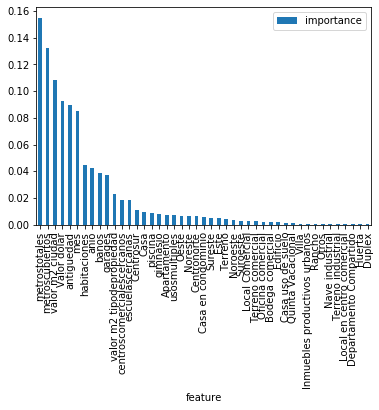

In [7]:
df = pd.DataFrame({'feature':x.columns, 'importance':model.feature_importances_})
df = df.set_index('feature')
df = df.sort_values(by='importance', ascending=False)
# print(xgb_random.best_params_)
print(df.index)  
df.plot(kind='bar')

In [9]:
xgb_predict = model.predict(test.drop(['id'], axis=1))
res = pd.DataFrame(xgb_predict, index=test.id, columns=['precio'])
res = res.rename({'precio':'target'}, axis=1)
res.to_csv("predictions/xgb_predictions.csv", header = True)